In [9]:
from discretizer import discretizer
from privacy_mechanism import LapU
import torch
device = torch.device("cpu")
import matplotlib.pyplot as plt

# testing the discretizer

In [11]:
data_conti = torch.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0.6],
    [0, 0, 0.6, 0],
    [0, 0, 0.6, 0.6],
    [0, 0.6, 0, 0],
    [0, 0.6, 0, 0.6],
    [0, 0.6, 0.6, 0],
    [0, 0.6, 0.6, 0.6],   
    [0.6, 0, 0, 0],
    [0.6, 0, 0, 0.6],
    [0.6, 0, 0.6, 0],
    [0.6, 0, 0.6, 0.6],
    [0.6, 0.6, 0, 0],
    [0.6, 0.6, 0, 0.6],
    [0.6, 0.6, 0.6, 0],
    [0.6, 0.6, 0.6, 0.6],
])
dsc = discretizer(device)
data_disc, n_category = dsc.transform(data_conti, 2)
data_disc

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

# testing the LapU for discrete data

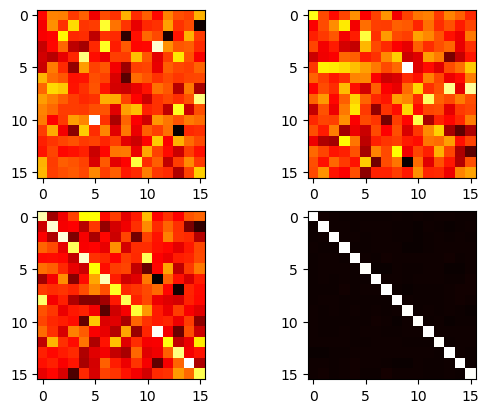

In [23]:
laputest = LapU(device)
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(laputest.privatize(data_disc, n_category, 0.1), cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(laputest.privatize(data_disc, n_category, 1.0), cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(laputest.privatize(data_disc, n_category, 10), cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(laputest.privatize(data_disc, n_category, 1000), cmap = 'hot', interpolation = 'nearest')

In [37]:
data_onehot = torch.nn.functional.one_hot(data_disc, n_category)

tensor([[ 4.0000e+00, -1.0375e-05, -8.5015e-06, -4.4412e-05,  9.6365e-05,
         -2.0399e-04, -4.9341e-05, -1.6360e-04, -6.9006e-05, -6.6307e-05,
         -2.8768e-04,  7.0406e-06, -4.3358e-05,  4.9309e-04, -2.1697e-04,
         -1.2917e-05],
        [ 1.2655e-04,  4.0001e+00, -6.2687e-05,  2.4322e-04, -3.2684e-05,
          9.5714e-06, -2.9029e-05,  2.6871e-05, -3.3387e-05,  1.1297e-05,
         -2.9082e-05,  6.3987e-05, -1.4338e-05,  3.1538e-05, -5.6859e-05,
         -1.6859e-04],
        [ 2.9810e-04,  2.5187e-05,  4.0000e+00,  6.2329e-05, -1.0631e-04,
         -1.1414e-05,  1.1000e-04,  1.6171e-04,  8.9690e-05, -9.5819e-06,
          6.9423e-05,  6.2553e-05, -1.0662e-04, -8.1986e-05,  3.2530e-04,
          2.5537e-04],
        [-1.5065e-04,  4.1280e-05,  1.4378e-04,  3.9999e+00,  1.3820e-04,
          1.2701e-04,  1.8334e-05,  8.4918e-05, -4.2298e-05, -2.5294e-04,
         -1.0498e-05, -9.5334e-05,  1.4522e-04,  3.7804e-05, -5.2596e-05,
         -2.4418e-06],
        [-5.0305e-05

In [5]:
2**(1/2)

1.4142135623730951

In [2]:

m = torch.distributions.categorical.Categorical(torch.tensor([ 0.25, 0.25, 0.25, 0.25 ]))
multi_sample = m.sample(sample_shape = torch.Size([4]))
multi_sample

In [5]:
a

tensor([[1, 2, 3],
        [1, 2, 3]])

In [24]:
weights = torch.tensor([0, 10, 3, 0], dtype=torch.float) # create a tensor of weights
multi = torch.multinomial(weights, 2)
 return(torch.nn.functional.one_hot(data_multinomial, alphabet_size))

IndentationError: unexpected indent (2434617784.py, line 3)

tensor([3, 1, 1, 0])

In [ ]:
torch.nn.functional.one_hot(multi_sample, 4)

RuntimeError: Class values must be smaller than num_classes.